In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cirq
from xmps.iMPS import iMPS, Map
from qmps.represent import get_env_exact, FullStateTensor, Environment
from qmps.tools import unitary_to_tensor, environment_from_unitary
from scipy.linalg import expm
from qmps.ground_state import Hamiltonian
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib as mpl
mpl.style.use('pub_fast')
from qmps.represent import ShallowFullStateTensor
from qmps.tools import tensor_to_unitary
from qmps.rotosolve import gate as gate_
from scipy.linalg import null_space, norm
from tqdm import tqdm_notebook
from xmps.spin import paulis
from qmps.represent import ShallowFullStateTensor
from qmps.tools import tensor_to_unitary
from qmps.rotosolve import gate
from scipy.linalg import null_space
I, X, Y, Z = np.eye(2), *paulis(0.5)
def merge(A, B):
    return np.tensordot(A, B, [2, 1]).transpose([0, 2, 1, 3]).reshape(2*A.shape[0], 2, 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def put_env_on_left_site(q, ret_n=False):
    # Take a matrix q (2x2) and create U such that 
    # (right 0-|---|--0
    #          | u |        =  q_{ij}
    # (left) i-|---|--j 
    q = q.T
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, c.conj(), b, d.conj()], [c, -a.conj(), d, -b.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    A = cirq.unitary(cirq.SWAP)@A
    if ret_n:
        return A, n
    else:
        return A
def get_env_off_left_site(A):
    z = np.array([1, 0])
    return np.tensordot(np.tensordot(A.reshape(2, 2, 2, 2), z, [3, 0]), z, [1, 0]).T

def put_env_on_right_site(q, ret_n=False):
    q = q
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, b, d.conj(), -c.conj()], [c, d, -b.conj(), a.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    #A = cirq.unitary(cirq.SWAP)@A
    if ret_n:
        return A, n
    else:
        return A

def get_env_off_right_site(A):
    z = np.array([1, 0])
    return np.tensordot(np.tensordot(A.reshape(2, 2, 2, 2), z, [2, 0]), z, [0, 0])
N = 50
for _ in range(50):
    q = np.random.randn(2, 2)+1j*np.random.randn(2, 2)
    assert np.allclose(get_env_off_left_site(np.prod(put_env_on_left_site(q, ret_n=True))), q)
    assert np.allclose(get_env_off_right_site(np.prod(put_env_on_right_site(q, ret_n=True))), q)
    U = put_env_on_left_site(q)
    V = put_env_on_right_site(q)
    assert np.allclose(V.conj().T@V, np.eye(U.shape[0]))
    assert np.allclose(U.conj().T@U, np.eye(U.shape[0]))
    
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    x, r = Map(merge(A, A), merge(B, B)).right_fixed_point()
    x_, l = Map(merge(A, A), merge(B, B)).left_fixed_point()
    L = put_env_on_right_site(l)
    R = put_env_on_left_site(r)
    assert np.allclose(get_env_off_left_site(put_env_on_left_site(r)), r)
    assert np.allclose(get_env_off_right_site(put_env_on_right_site(l)), l)
    U = put_env_on_left_site(r)
    V = put_env_on_right_site(l)
    assert np.allclose(V.conj().T@V, np.eye(U.shape[0]))
    assert np.allclose(U.conj().T@U, np.eye(U.shape[0]))

In [16]:
N = 10
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

    E = Map(A, B)

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()


    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')


    qbs = cirq.LineQubit.range(4)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[1]), cirq.CNOT(*qbs[1:3]), 
                                   R(*qbs[2:]),
                                   g[0](qbs[1]),
                                   cirq.CNOT(*qbs[1:3]), cirq.H(qbs[1])])
        s = cirq.Simulator()
        assert np.allclose(2*s.simulate(C).final_state[0]-np.trace(g[1]@r), 0, 1e-6, 1e-6)
    # r is the matrix on the 1st qubit

    qbs = cirq.LineQubit.range(4)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[1]), cirq.CNOT(*qbs[1:3]),
                                   U(*qbs[0:2]),
                                   R(*qbs[2:]),
                                   g[0](qbs[0]),
                                   cirq.inverse(U_)(*qbs[0:2]),
                                   cirq.CNOT(*qbs[1:3]), cirq.H(qbs[1])])
        s = cirq.Simulator()
        assert np.allclose(2*s.simulate(C).final_state[0]-x*np.trace(g[1]@r), 0, 1e-6, 1e-6)

    qbs = cirq.LineQubit.range(5)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[2]), cirq.CNOT(*qbs[2:4]),
                                   U(*qbs[1:3]),
                                   U(*qbs[0:2]),
                                   R(*qbs[3:]),
                                   g[0](qbs[0]),
                                   cirq.inverse(U_)(*qbs[0:2]),
                                   cirq.inverse(U_)(*qbs[1:3]),
                                   cirq.CNOT(*qbs[2:4]), cirq.H(qbs[2])])
        s = cirq.Simulator()
        #print(C.to_text_diagram(transpose=True))
        #raise Exception
        assert np.allclose(2*s.simulate(C).final_state[0]-x**2*np.trace(g[1]@r), 0, 1e-6, 1e-6)


    qbs = cirq.LineQubit.range(3)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[1]), cirq.CNOT(*qbs[1:3]), 
                                   L(*qbs[:2]),
                                   g[0](qbs[2]),
                                   cirq.CNOT(*qbs[1:3]), cirq.H(qbs[1])])
        s = cirq.Simulator()

        assert np.allclose(2*s.simulate(C).final_state[0]-np.trace(g[1]@l.conj()), 0, 1e-6, 1e-6)
    # r is the matrix on the 1st qubit

    qbs = cirq.LineQubit.range(4)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[2]), cirq.CNOT(*qbs[2:4]),
                                   U(*qbs[1:3]),
                                   L(*qbs[:2]),
                                   g[0](qbs[3]),
                                   cirq.inverse(U_)(*qbs[1:3]),
                                   cirq.CNOT(*qbs[2:4]), cirq.H(qbs[2])])
        s = cirq.Simulator()
        #print(C.to_text_diagram(transpose=True))
        #raise Exception
        assert np.allclose(2*s.simulate(C).final_state[0]-x*np.trace(g[1]@l.conj()), 0, 1e-6, 1e-6)

    qbs = cirq.LineQubit.range(5)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                                   U(*qbs[2:4]),
                                   U(*qbs[1:3]),
                                   L(*qbs[0:2]),
                                   g[0](qbs[4]),
                                   cirq.inverse(U_)(*qbs[1:3]),
                                   cirq.inverse(U_)(*qbs[2:4]),
                                   cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
        s = cirq.Simulator()
        assert np.allclose(2*s.simulate(C).final_state[0]-x**2*np.trace(g[1]@l.conj()), 0, 1e-6, 1e-6)

    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    s = cirq.Simulator()
    assert np.allclose(2*s.simulate(C).final_state[0], x**2*np.trace(l.conj().T@r))

<IPython.core.display.Javascript object>


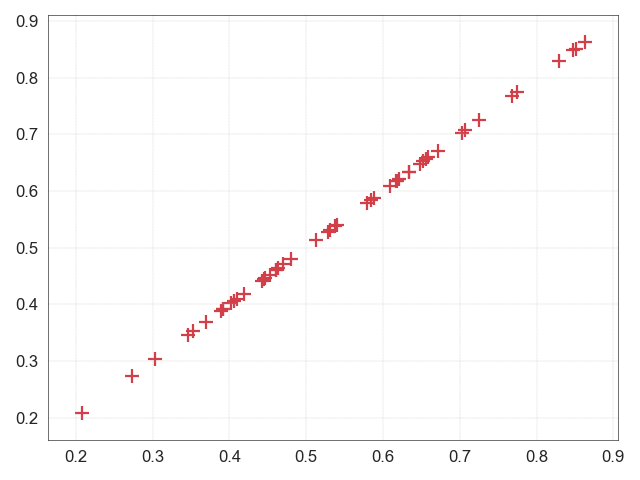

In [17]:
fids = []
N = 50
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

    E = Map(A, B)

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()


    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')
    
    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]),
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]), 
                                   cirq.H(qbs[1])])
    s = cirq.Simulator()
    fids.append([s.simulate(C).final_state[0]/s.simulate(normC).final_state[0], x[0]**2])
fids = np.array(fids)
plt.scatter(np.abs(fids[:, 0]), np.abs(fids[:, 1]), marker='+');

<IPython.core.display.Javascript object>


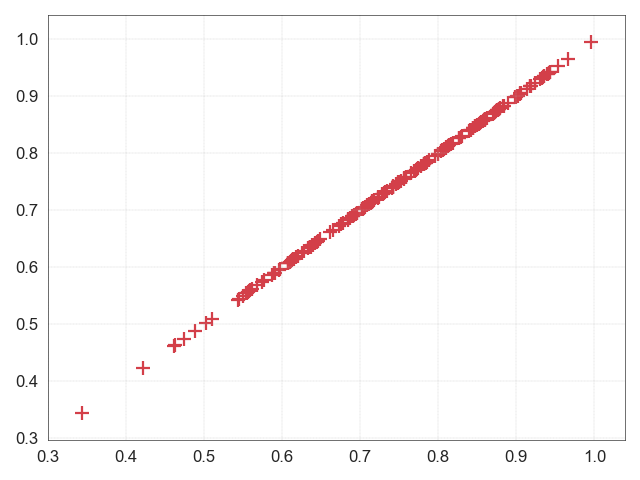

In [28]:
plt.figure()
fids = []
N = 200
dt = 5
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    #B = np.tensordot(expm(-1j*Z*dt), A, [1, 0])
    B = iMPS().random(2, 2).left_canonicalise()[0]
    #BB = np.tensordot(expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt), merge(, B), [1, 0])

    E = Map(merge(A, A), merge(B, B))

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()
    #r = np.eye(2)/np.sqrt(2)
    #l = np.eye(2)/np.sqrt(2)

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    left = put_env_on_right_site(l.conj().T)
    L = Environment(left, 'L')
    
    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]), 
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]),
                                   cirq.H(qbs[1])
                                   ])

    s = cirq.Simulator()
    fids.append([np.sqrt(np.abs(s.simulate(C).final_state[0])/np.abs(s.simulate(normC).final_state[0])), np.sqrt(np.abs(x[0]))])
fids = np.array(fids)
plt.scatter(np.abs(fids[:, 0]), np.abs(fids[:, 1]), marker='+');

<IPython.core.display.Javascript object>


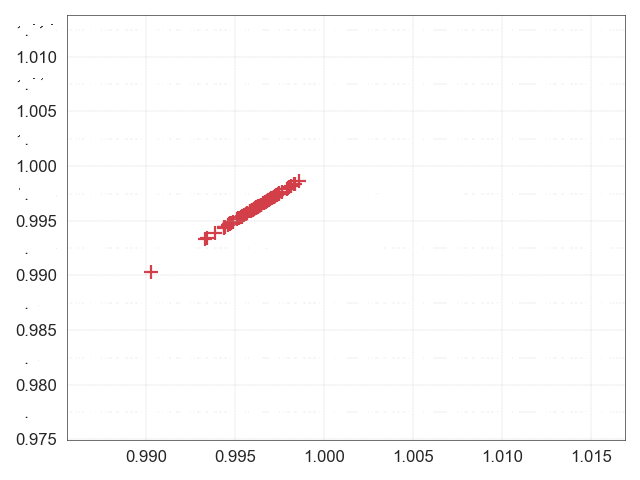

In [18]:
plt.figure()
fids = []
N = 100
dt = 0.1
WW = expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt)

for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = A

    E = Map(np.tensordot(WW, merge(A, A), [1, 0]), merge(B, B))

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()
    #r = np.eye(2)/np.sqrt(2)
    #l = np.eye(2)/np.sqrt(2)

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    left = put_env_on_right_site(l.conj().T)
    L = Environment(left, 'L')
    
    W = Environment(WW, 'W')
    
    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               W(*qbs[2:4]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]), 
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]),
                                   cirq.H(qbs[1])
                                   ])
    s = cirq.Simulator()
    ff = np.sqrt(np.abs(s.simulate(C).final_state[0])/np.abs(s.simulate(normC).final_state[0])), np.sqrt(np.abs(x[0]))
    fids.append(ff)
fids = np.array(fids)
plt.scatter(np.abs(fids[:, 0]), np.abs(fids[:, 1]), marker='+');

In [84]:
from scipy.optimize import minimize

def gate(v, symbol='U'):
    #return ShallowCNOTStateTensor(2, v[:-1])
    return ShallowFullStateTensor(2, v, symbol)
    #return FullStateTensor(U4(v))
#A = iMPS().random(2, 2).left_canonicalise()[0]
dt = 0.1

def obj(p, A, WW):
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]

    E = Map(np.tensordot(WW, merge(A, A), [1, 0]), merge(B, B))

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()
    l = r
    #r = np.eye(2)/np.sqrt(2)
    #l = np.eye(2)/np.sqrt(2)

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'θR')
    left = put_env_on_right_site(l.conj().T)
    L = Environment(left, 'θL')
    
    W = Environment(WW, 'W')

    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               W(*qbs[2:4]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]), 
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]),
                                   cirq.H(qbs[1])
                                   ])
    s = cirq.Simulator(dtype=np.complex128)
    ff = np.sqrt(2*np.abs(s.simulate(C).final_state[0]))#/np.abs(s.simulate(normC).final_state[0])), np.sqrt(np.abs(x[0]))
    #print(ff[0]-ff[1])
    #print(ff[0], ff[1])
    return -ff

#print(res.x, res.fun)

#A = iMPS().random(2, 2).left_canonicalise()

T = np.linspace(0, 5, 50)
dt = T[1]-T[0]
res = minimize(obj, np.random.randn(15), 
               (A[0], np.eye(4)), 
               method='Nelder-Mead',
               options={'disp':True})
params = res.x

WW = expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt)
ps = [params]
ops = paulis(0.5)
evs = []
les = []
for _ in tqdm_notebook(T):
    A_ = iMPS([unitary_to_tensor(cirq.unitary(gate(params)))]).left_canonicalise()
    evs.append(A_.Es(ops))
    les.append(A_.overlap(A))
    res = minimize(obj, params, (A_[0], WW), options={'disp':True})
    params = res.x
    ps.append(params)

0  1  2  3
│  │  │  │
│  H  │  │
│  │  │  │
│  @──X  │
│  │  │  │
θL─θL θR─θR
│  │  │  │
│  @──X  │
│  │  │  │
│  H  │  │
│  │  │  │


Exception: 

<IPython.core.display.Javascript object>


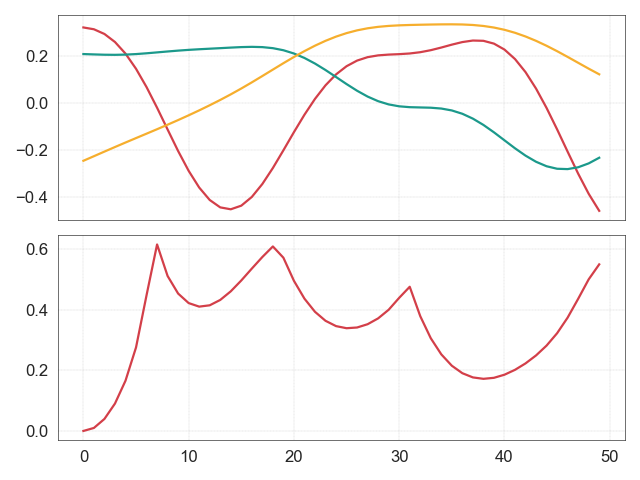

In [62]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(evs)
ax[1].plot(-np.log(np.array(les)))

In [77]:
from scipy.optimize import minimize

def gate(v, symbol='U'):
    #return ShallowCNOTStateTensor(2, v[:-1])
    return ShallowFullStateTensor(2, v, symbol)
    #return FullStateTensor(U4(v))
#A = iMPS().random(2, 2).left_canonicalise()[0]
dt = 0.1

def obj(p, A, WW):
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    p, rs = p[:15], p[15:]
    
    r = (rs[:4]+1j*rs[4:]).reshape(2, 2)
    r/=np.sqrt(np.trace(r.conj().T@r))
    l = r
    
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')
    
    W = Environment(WW, 'W')

    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               W(*qbs[2:4]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    #qbs = cirq.LineQubit.range(4)
    #normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
    #                               cirq.CNOT(*qbs[1:3]),
    #                               L(*qbs[:2]), 
    #                               R(*qbs[-2:]),
    #                               cirq.CNOT(*qbs[1:3]),
    #                               cirq.H(qbs[1])
    #                               ])
    s = cirq.Simulator(dtype=np.complex128)
    #b = np.abs(s.simulate(normC).final_state[0])
    ff = np.sqrt(np.abs(2*s.simulate(C).final_state[0]))
    return -ff

#print(res.x, res.fun)

#A = iMPS().random(2, 2).left_canonicalise()

T = np.linspace(0, 5, 50)
dt = T[1]-T[0]
res = minimize(obj, np.random.randn(23), 
               (A[0], np.eye(4)), 
               method='Nelder-Mead',
               options={'disp':True})
params = res.x

WW = expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt)
ps = [params]
ops = paulis(0.5)
evs = []
les = []
for _ in tqdm_notebook(T[1:]):
    A_ = iMPS([unitary_to_tensor(cirq.unitary(gate(params)))]).left_canonicalise()
    evs.append(A_.Es(ops))
    les.append(A_.overlap(A))
    res = minimize(obj, params, (A_[0], WW), options={'disp':True})
    params = res.x
    ps.append(params)

         Current function value: -0.996131
         Iterations: 7
         Function evaluations: 1857
         Gradient evaluations: 74
         Current function value: -0.997492
         Iterations: 36
         Function evaluations: 2359
         Gradient evaluations: 94
         Current function value: -0.997387
         Iterations: 11
         Function evaluations: 1937
         Gradient evaluations: 77
         Current function value: -0.997399
         Iterations: 63
         Function evaluations: 4558
         Gradient evaluations: 182
         Current function value: -0.997525
         Iterations: 18
         Function evaluations: 1009
         Gradient evaluations: 40


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.997730
         Iterations: 24
         Function evaluations: 1965
         Gradient evaluations: 78
         Current function value: -0.998015
         Iterations: 21
         Function evaluations: 1920
         Gradient evaluations: 76
         Current function value: -0.998359
         Iterations: 13
         Function evaluations: 1462
         Gradient evaluations: 58


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.998724
         Iterations: 20
         Function evaluations: 1437
         Gradient evaluations: 57
         Current function value: -0.999073
         Iterations: 9
         Function evaluations: 1657
         Gradient evaluations: 66
         Current function value: -0.999367
         Iterations: 20
         Function evaluations: 1162
         Gradient evaluations: 46
         Current function value: -0.999601
         Iterations: 21
         Function evaluations: 1712
         Gradient evaluations: 68
         Current function value: -0.999760
         Iterations: 33
         Function evaluations: 2586
         Gradient evaluations: 103
         Current function value: -0.999853
         Iterations: 9
         Function evaluations: 981
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: -0.999899
         Iterations: 10
         Function evaluation

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Divide-by-zero encountered: rhok assumed large
         Current function value: -0.999661
         Iterations: 77
         Function evaluations: 5187
         Gradient evaluations: 207
         Current function value: -0.999485
         Iterations: 14
         Function evaluations: 1008
         Gradient evaluations: 40
         Current function value: -0.999247
         Iterations: 28
         Function evaluations: 2242
         Gradient evaluations: 89
         Current function value: -0.998959
         Iterations: 14
         Function evaluations: 1560
         Gradient evaluations: 62
         Current function value: -0.998645
         Iterations: 27
         Function evaluations: 1871
         Gradient evaluations: 74
         Current function value: -0.998325
         Iterations: 19
         Function evaluations: 737
         Gradient evaluations: 29
         Current function value: -0.998022
         Iterations: 5
         Function evaluations: 1235
         Gradient evaluations

<IPython.core.display.Javascript object>


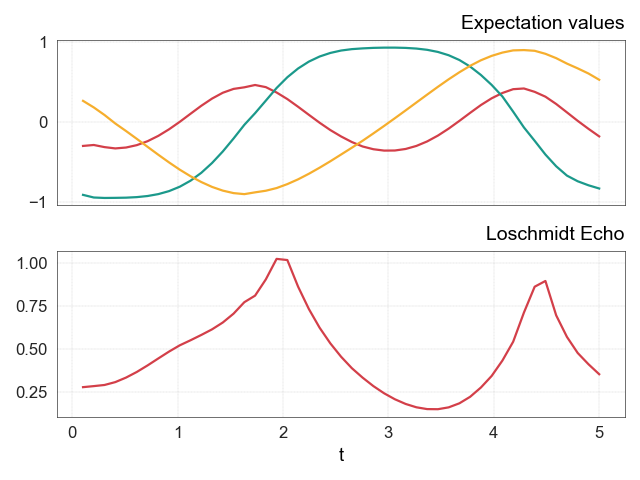

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [82]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(T[1:], evs)
ax[1].plot(T[1:], -np.log(np.array(les)))
ax[0].set_title('Expectation values', loc='right')
ax[1].set_title('Loschmidt Echo', loc='right')
ax[1].set_xlabel('t')
plt.savefig('/Users/fergusbarratt/Desktop/evs_les.pdf', bbox_inches='tight')

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


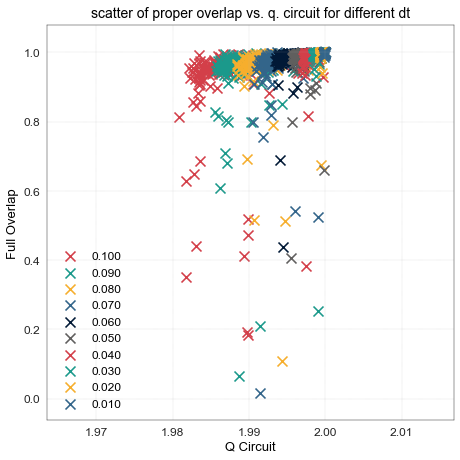

In [34]:
H = Hamiltonian({'ZZ': -1, 'X':1}).to_matrix()
plt.figure()
for dt in tqdm_notebook(np.linspace(0.1, 0.01, 10)):
    cqs = []
    for _ in tqdm_notebook(range(200)):
        U = np.linalg.qr(np.random.randn(4, 4))[0]
        #U_ = U#np.linalg.qr(np.random.randn(4, 4))[0]
        V = get_env_exact(U)
        #V_ = V#get_env_exact(U_)
        A = iMPS([unitary_to_tensor(U)]).left_canonicalise()[0]
        B = iMPS([(A+dt*iMPS([A]).dA_dt([H]).data[0])]).left_canonicalise()[0]

        evo = Environment(expm(-1j*dt*H), 'e^-i*dt*H')
        qbs = cirq.LineQubit.range(4)
        C = cirq.Circuit().from_ops([Environment(V, 'V')(*qbs[2:]), FullStateTensor(U)(*qbs[1:3]), FullStateTensor(U)(*qbs[:2])])
        C.append(evo(*qbs[1:3]))
        C.append([cirq.inverse(Environment(U, 'U')(*qbs[:2])), cirq.inverse(Environment(U, 'U')(*qbs[1:3])), cirq.inverse(Environment(V, 'V')(*qbs[2:]))])
        s = cirq.Simulator()
        ψ = s.simulate(C).final_state
        c = ψ[0]
        q = Map(A, B).left_fixed_point()[0]
        cqs.append([np.abs(c)*2, np.abs(q)**4])
    cqs = np.array(cqs)
    plt.scatter(cqs[:, 0], cqs[:, 1], marker='x', label='{:.3f}'.format(dt));
    plt.xlabel('Q Circuit')
    plt.ylabel('Full Overlap')
#plt.xlim([0, 1.1])
#plt.ylim([0.5, 1.1])
plt.legend(loc=3)
fig = plt.gcf()
fig.set_size_inches(6.5, 6.5)
plt.title('scatter of proper overlap vs. q. circuit for different dt')
plt.savefig('/Users/fergusbarratt/Desktop/overlap_approx.pdf', bbox_inches='tight')

In [7]:

qbs = cirq.LineQubit.range(6)
U = Environment(tensor_to_unitary(A), 'U')
U_ = Environment(tensor_to_unitary(B), 'U\'')
θ = np.random.randn(15)
ϕ = np.random.randn(15)
C = cirq.Circuit().from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]), U(*qbs[2:4]), U(*qbs[1:3]), 
                             gate(θ, 'θL')(*qbs[:2]), gate(ϕ, 'θR')(*qbs[-2:]),
                             cirq.inverse(U_)(*qbs[1:3]), cirq.inverse(U_)(*qbs[2:4]), cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
                             
print(C.to_text_diagram(transpose=True))


0  1   2   3   4  5
│  │   │   │   │  │
│  │   │   H   │  │
│  │   │   │   │  │
│  │   │   @───X  │
│  │   │   │   │  │
│  │   U───U   θR─θR
│  │   │   │   │  │
│  U───U   │   │  │
│  │   │   │   │  │
θL─θL  │   │   │  │
│  │   │   │   │  │
│  U'†─U'† │   │  │
│  │   │   │   │  │
│  │   U'†─U'† │  │
│  │   │   │   │  │
│  │   │   @───X  │
│  │   │   │   │  │
│  │   │   H   │  │
│  │   │   │   │  │


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


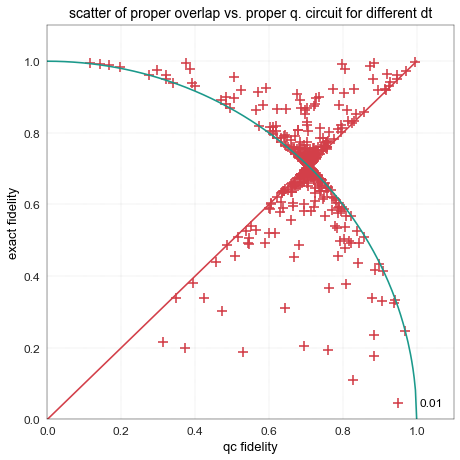

In [5]:
from xmps.spin import paulis
I, X, Y, Z = np.eye(2), *paulis(0.5)
qbs = cirq.LineQubit.range(6)
N = 500
plt.figure()
for dt in tqdm_notebook([0.01]):
    cc = []

    for _ in tqdm_notebook(range(N)):
        A = iMPS().random(2, 2).left_canonicalise()[0]
        B = iMPS([np.tensordot(expm(-1j*Y*dt), A, [1, 0])]).left_canonicalise()[0]
        #B = iMPS().random(2, 2).left_canonicalise()[0]
        
        U = Environment(tensor_to_unitary(A), 'U')
        U_ = Environment(tensor_to_unitary(B), 'U\'')

        E = Map(merge(A, A), merge(B, B))

        x, r = E.right_fixed_point()
        x_, l = E.left_fixed_point()

        L = Environment(put_env_on_right_site(l), 'L')
        R = Environment(put_env_on_left_site(r), 'R')

        U = Environment(tensor_to_unitary(A), 'U')
        U_ = Environment(tensor_to_unitary(B), 'U\'')

        assert np.allclose(get_env_off_left_site(put_env_on_left_site(l, ret_n=False)), l)  # l and r always normalised
        assert np.allclose(get_env_off_right_site(put_env_on_right_site(r, ret_n=False)), r)#


        qbs = cirq.LineQubit.range(6)

        C = cirq.Circuit().from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]), U(*qbs[2:4]), U(*qbs[1:3]), 
                                     L(*qbs[:2]), R(*qbs[-2:]),
                                     cirq.inverse(U_)(*qbs[1:3]), cirq.inverse(U_)(*qbs[2:4]), cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])

        #print(C.to_text_diagram(transpose=True))
        s = cirq.Simulator()
        ψ = s.simulate(C).final_state
        #print(ψ)
        cc.append([2*np.abs(ψ[0]), np.abs(x*np.trace(l.conj().T@r))])

    cc = np.array(cc)
    plt.scatter(cc[:, 0], cc[:, 1], marker='+', label='{}'.format(dt))
plt.xlim([0., 1.1])
plt.ylim([0., 1.1])
plt.legend(loc=4)
fig = plt.gcf()
fig.set_size_inches(6.5, 6.5)
plt.title('scatter of proper overlap vs. proper q. circuit for different dt')
#plt.plot(2*cc[:, 0], 2*cc[:, 0], c='black')
x = np.linspace(0, 1, 300)
plt.plot(x, x)
plt.plot(x, np.sqrt(1-x**2))
plt.xlabel('qc fidelity')
plt.ylabel('exact fidelity');

In [589]:
A = iMPS().random(2, 2).left_canonicalise()[0]
B = np.tensordot(expm(-1j*Z*dt), A, [1, 0])

E = Map(A, B)
E_ = Map(merge(A, A), merge(B, B))

In [594]:
E.left_fixed_point()[1]

array([[ 0.76069374+0.j        ,  0.01845563-0.04822254j],
       [ 0.01895358+0.03695733j, -0.5943911 +0.25229575j]])

In [593]:
E_.left_fixed_point()[1]

array([[ 0.76069374+1.38777878e-17j,  0.01845563-4.82225368e-02j],
       [ 0.01895358+3.69573324e-02j, -0.5943911 +2.52295750e-01j]])